##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# tf.dataを使って画像をロードする

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

このチュートリアルでは、'tf.data'を使って画像データセットをロードする簡単な例を示します。

このチュートリアルで使用するデータセットは、クラスごとに別々のディレクトリに別れた形で配布されています。

## 設定

In [2]:
!pip install tf-nightly

In [3]:
import tensorflow as tf
tf.enable_eager_execution()
tf.VERSION

'1.13.1'

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## データセットのダウンロードと検査

### 画像の取得

訓練を始める前に、ネットワークに認識すべき新しいクラスを教えるために画像のセットが必要です。最初に使うためのクリエイティブ・コモンズでライセンスされた花の画像のアーカイブを作成してあります。

In [5]:
import pathlib
data_root = tf.keras.utils.get_file('flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', untar=True)
data_root = pathlib.Path(data_root)
print(data_root)

/Users/masatoshi/.keras/datasets/flower_photos


218MBをダウンロードすると、花の画像のコピーが使えるようになっているはずです。

In [6]:
for item in data_root.iterdir():
    print(item)

/Users/masatoshi/.keras/datasets/flower_photos/roses
/Users/masatoshi/.keras/datasets/flower_photos/sunflowers
/Users/masatoshi/.keras/datasets/flower_photos/daisy
/Users/masatoshi/.keras/datasets/flower_photos/dandelion
/Users/masatoshi/.keras/datasets/flower_photos/tulips
/Users/masatoshi/.keras/datasets/flower_photos/LICENSE.txt


In [7]:
import random
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [8]:
all_image_paths

['/Users/masatoshi/.keras/datasets/flower_photos/dandelion/7179487220_56e4725195_m.jpg',
 '/Users/masatoshi/.keras/datasets/flower_photos/dandelion/18282528206_7fb3166041.jpg',
 '/Users/masatoshi/.keras/datasets/flower_photos/daisy/2713919471_301fcc941f.jpg',
 '/Users/masatoshi/.keras/datasets/flower_photos/dandelion/9011235009_58c7b244c1_n.jpg',
 '/Users/masatoshi/.keras/datasets/flower_photos/tulips/2232289392_9a79a0c5cb_n.jpg',
 '/Users/masatoshi/.keras/datasets/flower_photos/tulips/4522153453_06437ca3af_m.jpg',
 '/Users/masatoshi/.keras/datasets/flower_photos/roses/15184419268_7230e9728e.jpg',
 '/Users/masatoshi/.keras/datasets/flower_photos/daisy/476857510_d2b30175de_n.jpg',
 '/Users/masatoshi/.keras/datasets/flower_photos/tulips/9831362123_5aac525a99_n.jpg',
 '/Users/masatoshi/.keras/datasets/flower_photos/dandelion/155646858_9a8b5e8fc8.jpg',
 '/Users/masatoshi/.keras/datasets/flower_photos/daisy/3848258315_ed2fde4fb4.jpg',
 '/Users/masatoshi/.keras/datasets/flower_photos/daisy/9

### 画像の検査

扱っている画像について知るために、画像のいくつかを見てみましょう。

In [9]:
attributions = (data_root/"LICENSE.txt").read_text(encoding="utf8").splitlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [10]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])
    

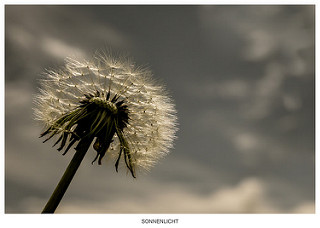

Image (CC BY 2.0)  by Norbert Reimer



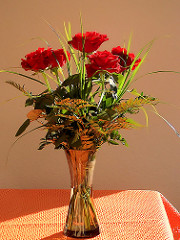

Image (CC BY 2.0)  by elbfoto



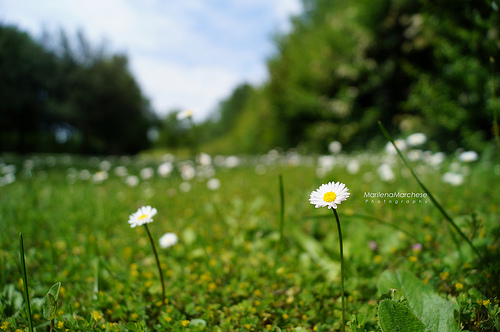

Image (CC BY 2.0)  by Marilena Marchese



In [11]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(caption_image(image_path))
    print()

### 各画像のラベルの決定

ラベルを一覧してみます。

In [12]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

ラベルにインデックスを割り当てます。

In [13]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

ファイルとラベルのインデックスの一覧を作成します。

In [14]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [1, 1, 0, 1, 4, 4, 2, 0, 4, 1]


### イメージのロードと整形

TensorFlowには画像をロードして処理するために必要なツールが備わっています。

In [15]:
img_path = all_image_paths[0]
img_path

'/Users/masatoshi/.keras/datasets/flower_photos/dandelion/7179487220_56e4725195_m.jpg'

これが生のデータです。

In [16]:
img_raw = tf.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: id=1, shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x...


画像のテンソルにデコードします。

In [17]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)

(240, 240, 3)
<dtype: 'uint8'>


モデルに合わせてリサイズします。

In [18]:
img_final = tf.image.resize_images(img_tensor, [192, 192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())


(192, 192, 3)
0.0
1.0


このあと使用するために、簡単な関数にまとめます。

In [19]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range

    return image

In [20]:
def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

In [21]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(label_names[label].title())
print()

## `tf.data.Dataset`の構築

### 画像のデータセット

`tf.data.Dataset`を構築する最も簡単な方法は、`from_tensor_slices`メソッドを使うことです。

文字列の配列をスライスすると、文字列のデータセットが出来上がります。

In [22]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

`output_shapes`と`output_types`という2つのフィールドが、データセット中の要素の中身を示しています。この場合には、バイナリ文字列というスカラーのセットです。

In [23]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


`preprocess_image`をファイルパスのデータセットにマップすることで、画像を実行時にロードし整形する新しいデータセットを作成します。

In [24]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

Instructions for updating:
Colocations handled automatically by placer.


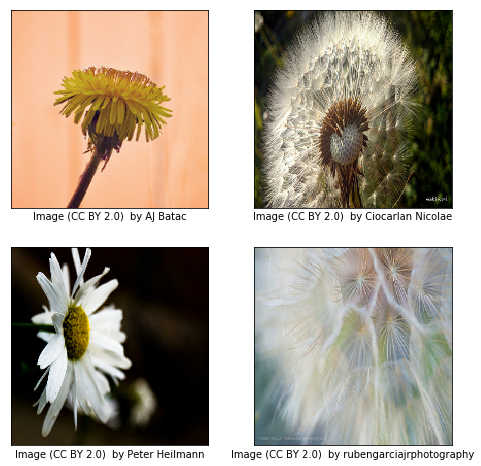

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))

###  `(image, label)`のペアのデータセット

同じ`from_tensor_slices`メソッドを使ってラベルのデータセットを作ることができます。

In [26]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [27]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])

dandelion
dandelion
daisy
dandelion
tulips
tulips
roses
daisy
tulips
dandelion


これらのデータセットは同じ順番なので、zipすることで`(image, label)`というペアのデータセットができます。

In [28]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

新しいデータセットの`shapes`と`types`は、それぞれのフィールドを示すシェイプと型のタプルです。

In [29]:
print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print()
print(image_label_ds)

image shape:  (192, 192, 3)
label shape:  ()
types:  (tf.float32, tf.int64)

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


注：`all_image_labels`や`all_image_paths`の配列がある場合、`tf.data.dataset.Dataset.zip`メソッドの代わりとなるのは、配列のペアをスライスすることです。

In [30]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
# タプルは解体され、マップ関数の位置引数に割り当てられます
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

### 基本的な訓練手法

このデータセットを使ってモデルの訓練を行うには、データが

* よくシャッフルされ
* バッチ化され
* 限りなく繰り返され
* バッチが出来るだけ早く利用できる

ことが必要です。

これらの特性は`tf.data`APIを使えば簡単に付け加えることができます。

In [31]:
BATCH_SIZE = 32

# シャッフルバッファのサイズをデータセットと同じに設定することで、データが完全にシャッフルされる
# ようにできます。
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch`を使うことで、モデルの訓練中にバックグラウンドでデータセットがバッチを取得できます。
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

注意すべきことがいくつかあります。

1. 順番が重要です。

  * `.repeat`の前に`.shuffle`すると、エポックの境界を越えて要素がシャッフルされます。（他の要素がすべて出現する前に2回出現する要素があるかもしれません）
  * `.batch`の後に`.shuffle`すると、バッチの順番がシャッフルされますが、要素がバッチを越えてシャッフルされることはありません。

1. 完全なシャッフルのため、`buffer_size`をデータセットと同じサイズに設定します。データセットのサイズ未満の場合、値が大きいほど良くランダム化されますが、より多くのメモリーを使用します。

1. シャッフルバッファがいっぱいになってから要素が取り出されます。そのため、大きな`buffer_size`が`Dataset`を使い始める際の遅延の原因になります。

1. シャッフルされたデータセットは、シャッフルバッファが完全に空になるまでデータセットが終わりであることを伝えません。`.repeat`によって`Dataset`が再起動されると、シャッフルバッファが一杯になるまでもう一つの待ち時間が発生します。

最後の問題は、`tf.data.Dataset.apply`メソッドを、融合された`tf.data.experimental.shuffle_and_repeat`関数を使うことで対処できます。

In [32]:
ds = image_label_ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

### データセットをモデルにつなぐ

`tf.keras.applications`からMobileNet v2のコピーを取得します。

これを簡単な転移学習のサンプルに使用します。

MobileNetの重みを訓練不可に設定します。

In [33]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False

このモデルは、入力が`[-1,1]`の範囲に正規化されていることを想定しています。

```
help(keras_applications.mobilenet_v2.preprocess_input)
```

<pre>
...
This function applies the "Inception" preprocessing which converts
the RGB values from [0, 255] to [-1, 1] 
...
</pre>

このため、データをMobileNetモデルに渡す前に、入力を`[0,1]`の範囲から`[-1,1]`の範囲に変換する必要があります。

In [34]:
def change_range(image,label):
    return 2*image-1, label

keras_ds = ds.map(change_range)

MobileNetは画像ごとに`6x6`の特徴量の空間を返します。

バッチを１つ渡してみましょう。

In [35]:
# シャッフルバッファがいっぱいになるまで、データセットは何秒かかかります。
image_batch, label_batch = next(iter(keras_ds))

In [36]:
feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)

(32, 6, 6, 1280)


MobileNetをラップしたモデルを作り、出力層である`tf.keras.layers.Dense`の前に、`tf.keras.layers.GlobalAveragePooling2D`で空間の軸に沿って平均値を求めます。

In [37]:
model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(label_names))])

期待したとおりのシェイプの出力が得られます。

In [38]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: -3.2900493
max logit: 2.763081

Shape: (32, 5)


訓練手法を記述するためにモデルをコンパイルします。

In [39]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

訓練可能な変数は2つ、全結合層の`weights`と`bias`です。

In [40]:
len(model.trainable_variables) 

2

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


モデルを訓練します。

普通は、エポックごとの本当のステップ数を指定しますが、ここではデモの目的なので3ステップだけとします。

In [42]:
steps_per_epoch=tf.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

115.0

In [43]:
model.fit(ds, epochs=1, steps_per_epoch=3)

3/3 [==============================] - 30s 10s/step - loss: 8.3349 - acc: 0.2812


## 性能

注：このセクションでは性能の向上に役立ちそうな簡単なトリックをいくつか紹介します。詳しくは、[Input Pipeline Performance](https://www.tensorflow.org/guide/performance/datasets)を参照してください。

上記の単純なパイプラインは、エポックごとにそれぞれのファイルを一つずつ読み込みます。これは、CPUを使ったローカルでの訓練では問題になりませんが、GPUを使った訓練では十分ではなく、いかなる分散訓練でも使うべきではありません。

調査のため、まず、データセットの性能をチェックする簡単な関数を定義します。

In [44]:
import time

def timeit(ds, batches=2*steps_per_epoch+1):
    overall_start = time.time()
    # タイマーをスタートする前に、パイプラインの初期化の（シャッフルバッファを埋める）ため、
    # バッチを１つ取得します
    it = iter(ds.take(batches+1))
    next(it)

    start = time.time()
    for i,(images,labels) in enumerate(it):
        if i%10 == 0:
            print('.',end='')
    print()
    end = time.time()

    duration = end-start
    print("{} batches: {} s".format(batches, duration))
    print("{:0.5f} Images/s".format(BATCH_SIZE*batches/duration))
    print("Total time: {}s".format(end-overall_start))

現在のデータセットの性能は次のとおりです。

In [45]:
ds = image_label_ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [46]:
timeit(ds)

........................
231.0 batches: 25.843446016311646 s
286.02997 Images/s
Total time: 43.207932233810425s


### キャッシュ

`tf.data.Dataset.cache`を使うと、エポックを越えて計算結果を簡単にキャッシュできます。特に、データがメモリに収まるときには効果的です。

ここでは、画像が前処理（デコードとリサイズ）された後でキャッシュされます。

In [47]:
ds = image_label_ds.cache()
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [48]:
timeit(ds)

........................
231.0 batches: 1.0587589740753174 s
6981.75900 Images/s
Total time: 14.936384201049805s


メモリキャッシュを使う際の欠点のひとつは、実行の都度キャッシュを再構築しなければならないことです。このため、データセットがスタートするたびに同じだけ起動のための遅延が発生します。

In [49]:
timeit(ds)

........................
231.0 batches: 1.0269150733947754 s
7198.25835 Images/s
Total time: 15.162395000457764s


データがメモリに収まらない場合には、キャッシュファイルを使用します。

In [50]:
ds = image_label_ds.cache(filename='./cache.tf-data')
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE).prefetch(1)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int32)>

In [51]:
timeit(ds)

........................
231.0 batches: 12.766232967376709 s
579.02750 Images/s
Total time: 33.048365116119385s


キャッシュファイルには、キャッシュを再構築することなくデータセットを再起動できるという利点もあります。2回めがどれほど早いか見てみましょう。

In [52]:
timeit(ds)

........................
231.0 batches: 9.893965005874634 s
747.12211 Images/s
Total time: 14.534404039382935s


### TFRecord ファイル

#### 生の画像データ

TFRecordファイルは、バイナリの大きなオブジェクトのシーケンスを保存するための単純なフォーマットです。複数のサンプルを同じファイルに詰め込むことで、TensorFlowは複数のサンプルを一度に読み込むことができます。これは、特にGCSのようなリモートストレージサービスを使用する際の性能にとって重要です。

最初に、生の画像データからTFRecordファイルを構築します。

In [53]:
image_ds = tf.data.Dataset.from_tensor_slices(all_image_paths).map(tf.read_file)
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(image_ds)

次に、TFRecordファイルを読み込み、以前定義した`preprocess_image`関数を使って画像のデコード/リフォーマットを行うデータセットを構築します。

In [54]:
image_ds = tf.data.TFRecordDataset('images.tfrec').map(preprocess_image)

これを、前に定義済みのラベルデータセットとzipし、予定される`(image,label)`のペアを得ます。

In [55]:
ds = tf.data.Dataset.zip((image_ds, label_ds))
ds = ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int64)>

In [56]:
timeit(ds)

........................
231.0 batches: 25.64651608467102 s
288.22628 Images/s
Total time: 38.50603103637695s


これは、`cache`バージョンよりも低速です。前処理をキャッシュしていないからです。

#### シリアライズしたテンソル

前処理をTFRecordファイルに保存するには、前やったように前処理した画像のデータセットを作ります。

In [57]:
paths_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = paths_ds.map(load_and_preprocess_image)
image_ds

<DatasetV1Adapter shapes: (192, 192, 3), types: tf.float32>

`.jpeg`文字列のデータセットではなく、これはテンソルのデータセットです。

これをTFRecordファイルにシリアライズするには、まず、テンソルのデータセットを文字列のデータセットに変換します。

In [58]:
ds = image_ds.map(tf.serialize_tensor)
ds

<DatasetV1Adapter shapes: (), types: tf.string>

In [59]:
tfrec = tf.data.experimental.TFRecordWriter('images.tfrec')
tfrec.write(ds)

前処理をキャッシュしたことにより、データはTFRecordファイルから非常に効率的にロードできます。テンソルを使用する前にデシリアライズすることを忘れないでください。

In [60]:
RESTORE_TYPE = image_ds.output_types
RESTORE_SHAPE = image_ds.output_shapes

ds = tf.data.TFRecordDataset('images.tfrec')

def parse(x):
    result = tf.parse_tensor(x, out_type=RESTORE_TYPE)
    result = tf.reshape(result, RESTORE_SHAPE)
    return result

ds = ds.map(parse, num_parallel_calls=AUTOTUNE)
ds

<DatasetV1Adapter shapes: (192, 192, 3), types: tf.float32>

次にラベルを追加し、以前と同じような標準的な処理を適用します。

In [61]:
ds = tf.data.Dataset.zip((ds, label_ds))
ds = ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds=ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int64)>

In [62]:
timeit(ds)

........................
231.0 batches: 9.515093088150024 s
776.87101 Images/s
Total time: 13.438390016555786s
